### Project presentation

https://docs.google.com/presentation/d/1A93wSz3j7fst8ygl16-Qpb69KdjiffkjnHZO9tPBghc/edit?usp=sharing

In [1]:
%%html
<iframe src="http://aspmhelp.faa.gov/index.php/ASPM_Airport_Analysis:_Definitions_of_Variables" width="900" height="400"></iframe>

# Code

### Initialize libraries and settings

In [2]:
# Data analysis
import pandas as pd
import numpy as np

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("fivethirtyeight")

# Optional
import warnings
warnings.filterwarnings('ignore')

### Import data

In [3]:
cancellations_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airport_cancellations.csv")
operations_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airport_operations.csv")
airports_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airports.csv")

In [4]:
operations_data = operations_raw_data.copy()
cancellations_data = cancellations_raw_data.copy()
airports_data = airports_raw_data.copy()

In [5]:
# Rename columns in "operations_data" to match case
for column_name in operations_data.columns:
    operations_data.rename(columns = {column_name: column_name.title()}, inplace = True)

In [6]:
master_dataframe = cancellations_data.merge(operations_data, on = ["Airport", "Year"])#.merge(airports_data.rename(columns = {"LocID": "Airport"}), on = ["Airport"])

In [7]:
data_dataframe = master_dataframe.copy()

In [8]:
# data_dataframe.drop(labels = ["Key", "Facility Type", "COUNTY", "Boundary Data Available"], axis = 1, inplace = True)
data_dataframe["Year"] = data_dataframe["Year"].astype(int)

### Data exploration

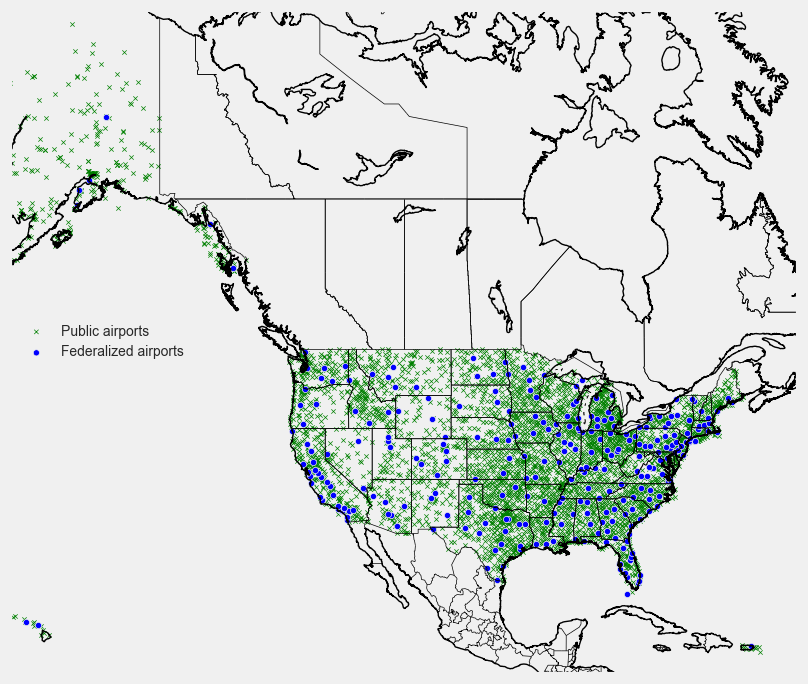

In [9]:
from mpl_toolkits.basemap import Basemap

map_fig = plt.figure(figsize=(10, 8))

map = Basemap(llcrnrlon=-160.,llcrnrlat=15.,urcrnrlon=-60.,urcrnrlat=70.,
             resolution='i', area_thresh = 6000, projection='merc')

map.drawcoastlines()
map.drawcountries()
map.drawstates()

all_airports_longitudes = airports_data[airports_data["AP Type"] != "Federalized/Commercial"]["Longitude"].tolist()
all_airports_latitudes = airports_data[airports_data["AP Type"] != "Federalized/Commercial"]["Latitude"].tolist()

x, y = map(all_airports_longitudes, all_airports_latitudes)
map.scatter(x, y, marker = 'x', color = 'g', s = 10, label = "Public airports")

federal_airports_longitudes = airports_data[airports_data["AP Type"] == "Federalized/Commercial"]["Longitude"].tolist()
federal_airports_latitudes = airports_data[airports_data["AP Type"] == "Federalized/Commercial"]["Latitude"].tolist()

x, y = map(federal_airports_longitudes, federal_airports_latitudes)
map.scatter(x, y, s = 20, label = "Federalized airports")

plt.legend(loc = 'center left')

plt.show()

In [ ]:
federal_airports_longitudes = airports_data[airports_data["AP Type"] == "Federalized/Commercial"]["Longitude"].tolist()
federal_airports_latitudes = airports_data[airports_data["AP Type"] == "Federalized/Commercial"]["Latitude"].tolist()

x, y = map(federal_airports_longitudes, federal_airports_latitudes)
map.scatter(x, y, s = 20, label = "Federalized airports")

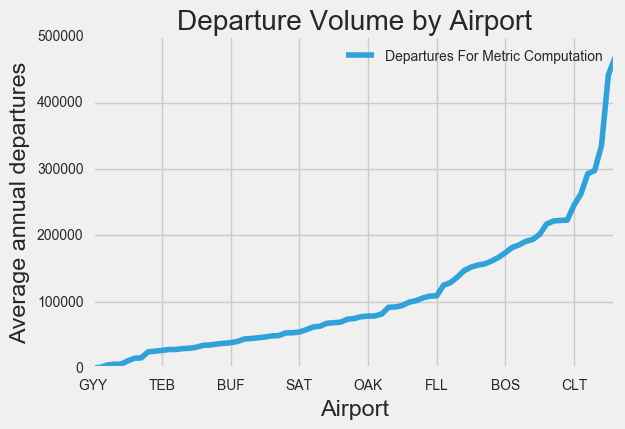

In [10]:
operations_data[["Airport", "Departures For Metric Computation"]].groupby("Airport").mean().sort_values("Departures For Metric Computation").plot()
plt.title("Departure Volume by Airport")
plt.ylabel("Average annual departures")
plt.show()

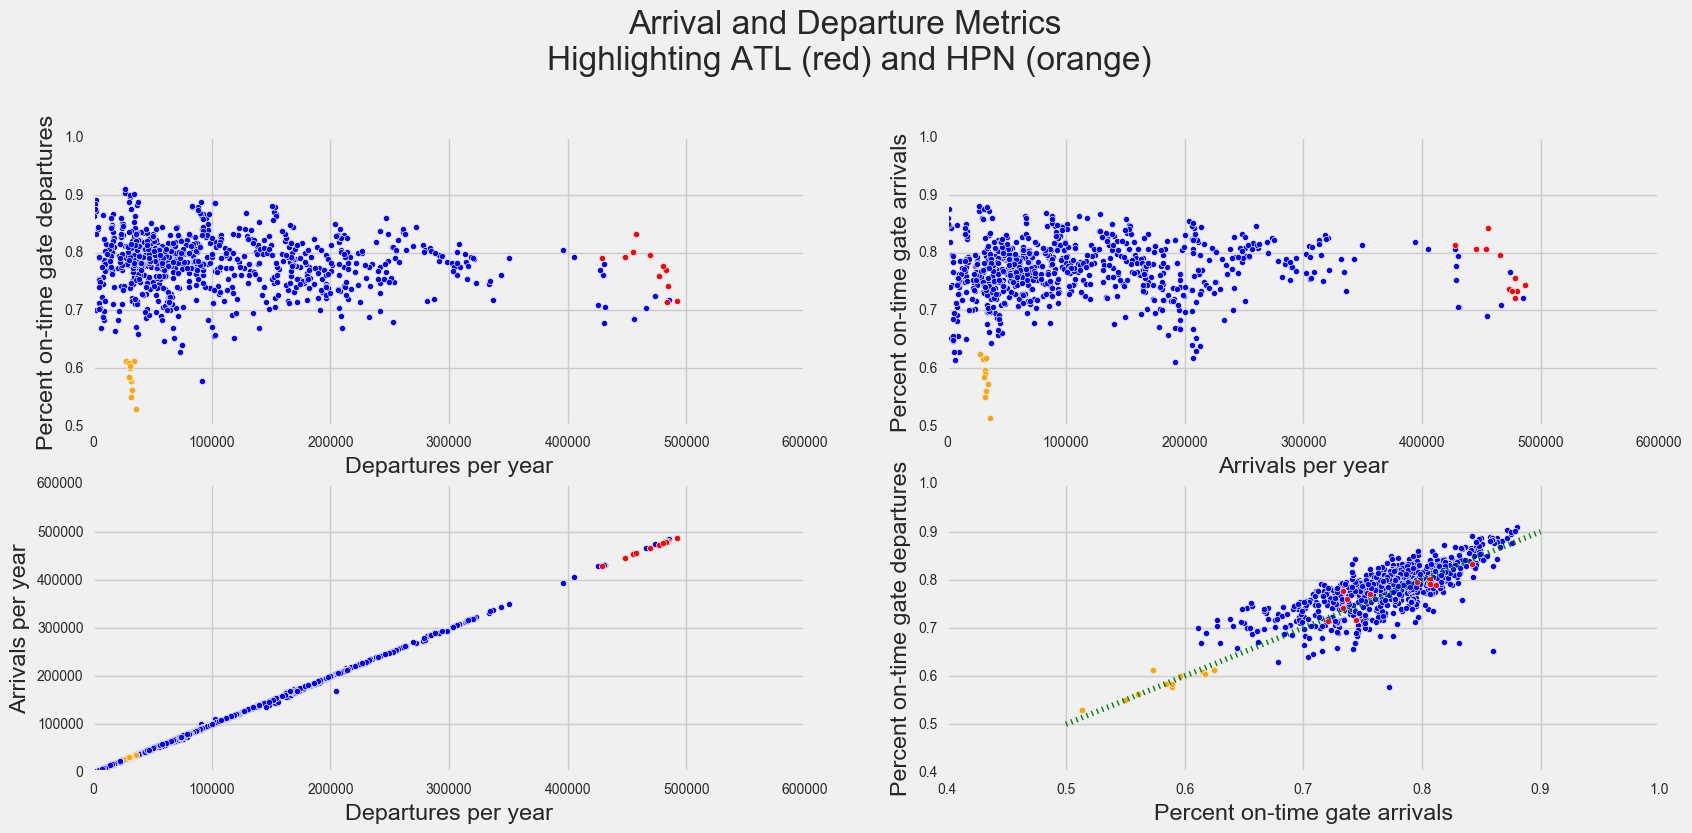

In [11]:
airport_comparison_fig = plt.figure(figsize=(18,16))

busiest_airport = {"Airport": "ATL", "color": 'red'}
least_efficient_airport = {"Airport": "HPN", "color": 'orange'}

airport_comparison_fig.suptitle("Arrival and Departure Metrics \nHighlighting {0} ({1}) and {2} ({3})".format(busiest_airport["Airport"], busiest_airport["color"], least_efficient_airport["Airport"], least_efficient_airport["color"]), fontsize = 24)

ax1 = airport_comparison_fig.add_subplot(421)
ax2 = airport_comparison_fig.add_subplot(422)
ax3 = airport_comparison_fig.add_subplot(423)
ax4 = airport_comparison_fig.add_subplot(424)

ax1.scatter(data_dataframe["Departures For Metric Computation"], data_dataframe["Percent On-Time Gate Departures"])
ax1.scatter(data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Departures For Metric Computation"], data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Percent On-Time Gate Departures"], c = busiest_airport["color"])
ax1.scatter(data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Departures For Metric Computation"], data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Percent On-Time Gate Departures"], c = least_efficient_airport["color"])
ax1.set_xlim(0, 600000)
ax1.set_ylim(0.5, 1.0)
ax1.set_xlabel("Departures per year")
ax1.set_ylabel("Percent on-time gate departures")

ax2.scatter(data_dataframe["Arrivals For Metric Computation"], data_dataframe["Percent On-Time Gate Arrivals"])
ax2.scatter(data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Arrivals For Metric Computation"], data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Percent On-Time Gate Arrivals"], c = busiest_airport["color"])
ax2.scatter(data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Arrivals For Metric Computation"], data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Percent On-Time Gate Arrivals"], c = least_efficient_airport["color"])
ax2.set_xlim(0, 600000)
ax2.set_ylim(0.5, 1.0)
ax2.set_xlabel("Arrivals per year")
ax2.set_ylabel("Percent on-time gate arrivals")

ax3.scatter(data_dataframe["Departures For Metric Computation"], data_dataframe["Arrivals For Metric Computation"])
ax3.scatter(data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Departures For Metric Computation"], data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Arrivals For Metric Computation"], c = busiest_airport["color"])
ax3.scatter(data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Departures For Metric Computation"], data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Arrivals For Metric Computation"], c = least_efficient_airport["color"])
ax3.set_xlim(0, 600000)
ax3.set_ylim(0, 600000)
ax3.set_xlabel("Departures per year")
ax3.set_ylabel("Arrivals per year")

ax4.plot([0.5,0.9], [0.5, 0.9], 'g:')
ax4.scatter(data_dataframe["Percent On-Time Gate Arrivals"], data_dataframe["Percent On-Time Gate Departures"])
ax4.scatter(data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Percent On-Time Gate Arrivals"], data_dataframe[data_dataframe["Airport"] == busiest_airport["Airport"]]["Percent On-Time Gate Departures"], c = busiest_airport["color"])
ax4.scatter(data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Percent On-Time Gate Arrivals"], data_dataframe[data_dataframe["Airport"] == least_efficient_airport["Airport"]]["Percent On-Time Gate Departures"], c = least_efficient_airport["color"])
ax4.set_xlim(0.4, 1.0)
ax4.set_ylim(0.4, 1.0)
ax4.set_xlabel("Percent on-time gate arrivals")
ax4.set_ylabel("Percent on-time gate departures")

plt.show()

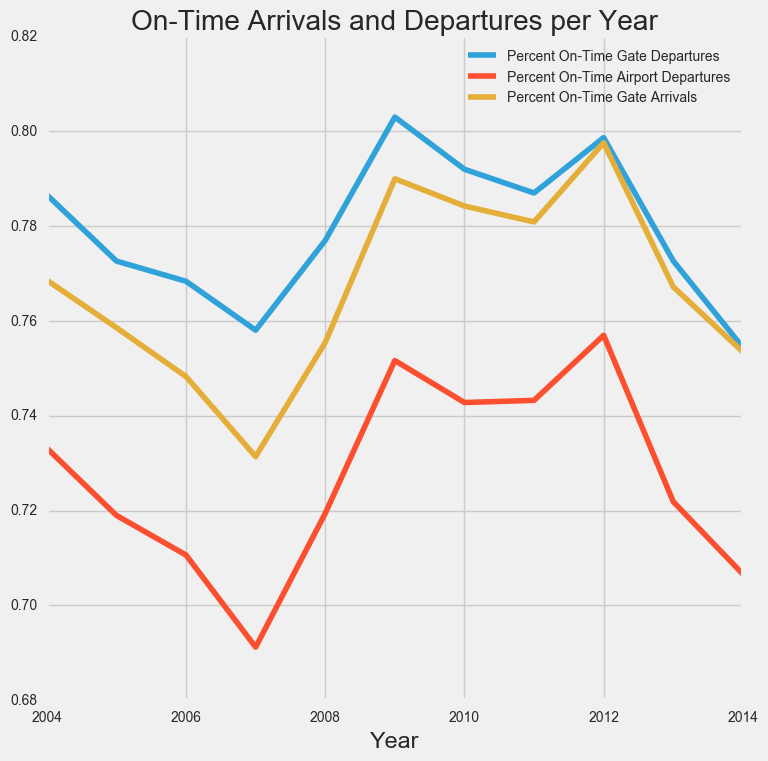

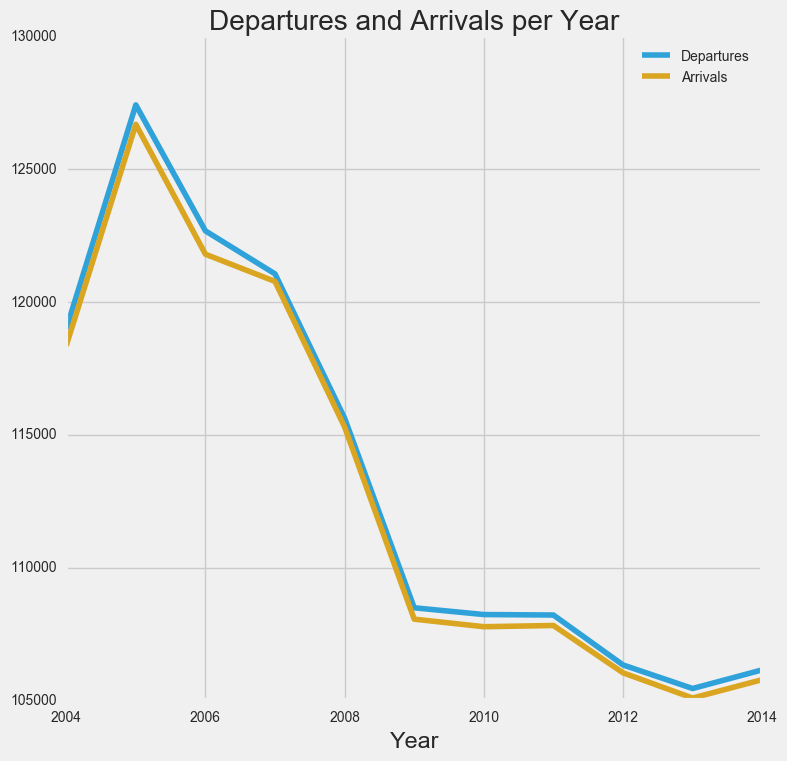

In [12]:
percent_on_time_figure = plt.figure(figsize=(8,8))
plt.plot(data_dataframe.groupby(by = "Year").mean()['Percent On-Time Gate Departures'], label = 'Percent On-Time Gate Departures')
plt.plot(data_dataframe.groupby(by = "Year").mean()['Percent On-Time Airport Departures'], label = 'Percent On-Time Airport Departures')
plt.plot(data_dataframe.groupby(by = "Year").mean()['Percent On-Time Gate Arrivals'], label = 'Percent On-Time Gate Arrivals')
plt.title("On-Time Arrivals and Departures per Year")
plt.legend(loc = 'best')
plt.xlabel("Year")
plt.show()

departures_arrivals_figure = plt.figure(figsize=(8,8))
plt.plot(data_dataframe.groupby(by = "Year").mean()['Departures For Metric Computation'], label = "Departures")
plt.plot(data_dataframe.groupby(by = "Year").mean()['Arrivals For Metric Computation'], label = "Arrivals", c = 'goldenrod')
plt.title("Departures and Arrivals per Year")
plt.legend()
plt.xlabel("Year")
plt.show()

In [13]:
# Per year, there are roughly 0.5% more departures than arrivals. 
(data_dataframe.groupby(by = "Year").mean()['Departures For Metric Computation'] - data_dataframe.groupby(by = "Year").mean()['Arrivals For Metric Computation'])

Year
2004    633
2005    732
2006    879
2007    284
2008    331
2009    428
2010    458
2011    394
2012    297
2013    359
2014    368
dtype: int64

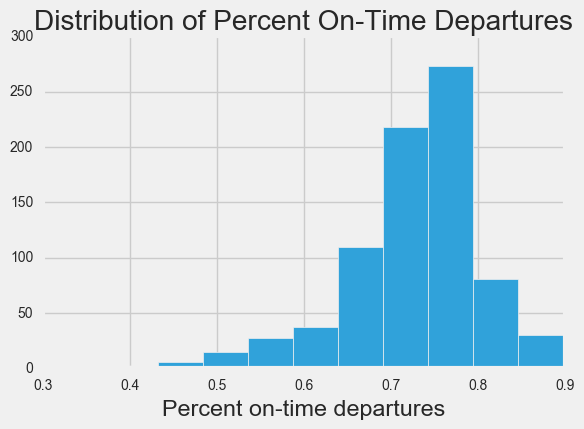

In [14]:
# kmeans = KMeans()
distribution_of_percent_on_time_departures = plt.figure()

data_dataframe["Percent On-Time Airport Departures"].hist()

plt.title("Distribution of Percent On-Time Departures")
plt.xlabel("Percent on-time departures")

plt.show()

### Analysis

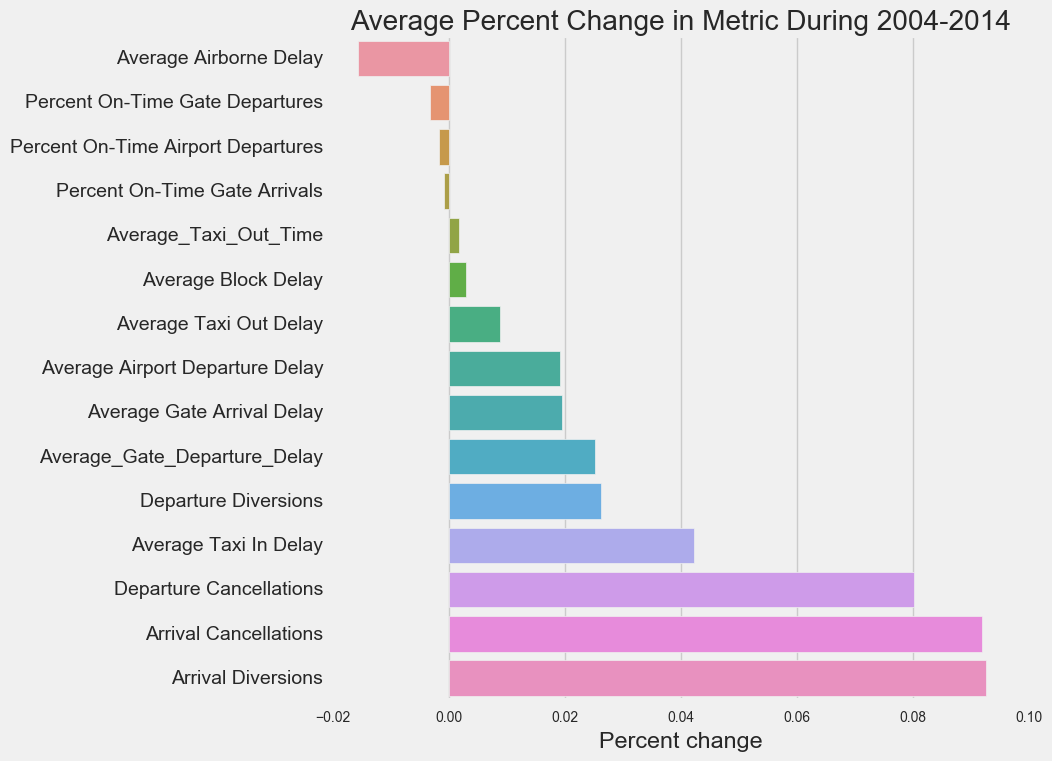

In [15]:
average_percent_change_dataframe = pd.DataFrame()

for airport in data_dataframe["Airport"].unique():
    average_change_by_airport = data_dataframe[data_dataframe["Airport"] == airport].ix[:, data_dataframe.dtypes == float].pct_change(periods = 1).mean()
    average_percent_change_dataframe = pd.concat(
        objs = [average_percent_change_dataframe, 
                pd.DataFrame(data = average_change_by_airport.reshape(1,-1), columns = data_dataframe.loc[:, data_dataframe.dtypes == float].columns)
               ])
    
average_percent_change_dataframe.replace(np.inf, value = 0, inplace = True)
average_percent_change_dataframe.reset_index(drop = True, inplace = True)
average_percent_change_dataframe["Airport"] = data_dataframe["Airport"].unique()
average_percent_change_dataframe["Airport"] = average_percent_change_dataframe["Airport"].astype('category')

sorted_average_percent_change_dataframe = average_percent_change_dataframe.mean().sort_values(ascending = True).to_frame(name = "Average percent change").T

percent_change_figure = plt.figure(figsize = (8,8))
sns.barplot(data = sorted_average_percent_change_dataframe, orient = 'h')
plt.title("Average Percent Change in Metric During 2004-2014")
plt.xlabel("Percent change")
plt.yticks(fontsize = 'medium')
plt.show()

#### Set X and y for PCA, clustering and classification

In [16]:
X = data_dataframe.drop(labels = ["Airport", "Percent On-Time Airport Departures"], axis = 1)
scaled_X = StandardScaler().fit_transform(X)
y = data_dataframe["Percent On-Time Airport Departures"]
engineered_y = round((y - y.mean()) / y.std())    # set y to the z-score for the percent on-time airport departures

#### Perform PCA

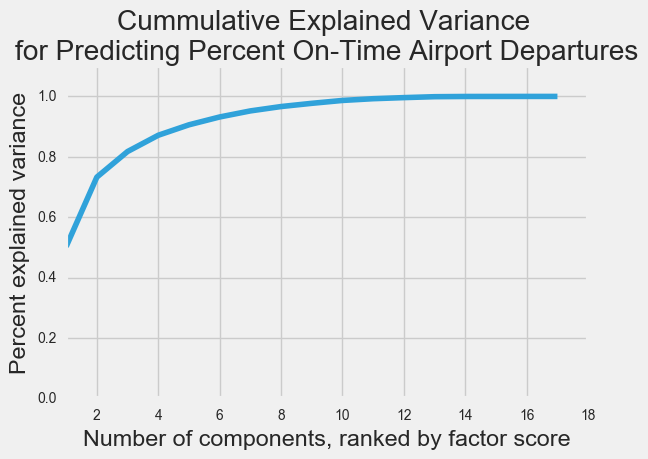

In [17]:
pca = PCA()
reduced_X = pca.fit_transform(scaled_X)
PCA_explained_variance = pca.explained_variance_ratio_

explained_variance_fig = plt.figure()
plt.plot(range(1, len(PCA_explained_variance) + 1), np.cumsum(PCA_explained_variance))
plt.xlim(1, len(PCA_explained_variance) + 1)
plt.ylim(0, 1.1)

plt.title("Cummulative Explained Variance \nfor Predicting Percent On-Time Airport Departures")
plt.xlabel("Number of components, ranked by factor score")
plt.ylabel("Percent explained variance")

plt.show()

#### K-Nearest Neighbors classification

In [18]:
kmeans = KMeans(n_clusters = len(engineered_y.unique()))

kmeans.fit_predict(reduced_X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
kmeans_score = kmeans.score(reduced_X)

In [19]:
kmeans_score

-4283.0341695024053

#### KNN classification

In [42]:
knn = KNeighborsClassifier(len(engineered_y.unique()))
knn.fit(reduced_X, engineered_y) 

knn_predictions = knn.predict(reduced_X)

knn_score = knn.score(reduced_X, engineered_y)
knn_CV_score = cross_val_score(knn, reduced_X, engineered_y, cv = 6).mean()
knn_CV_score

0.72833595874776835

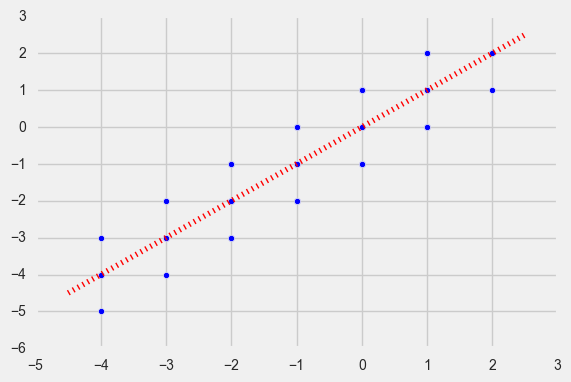

In [21]:
plt.scatter(knn_predictions, engineered_y)
plt.plot([-4.5,2.5], [-4.5, 2.5], 'r:')
plt.show()

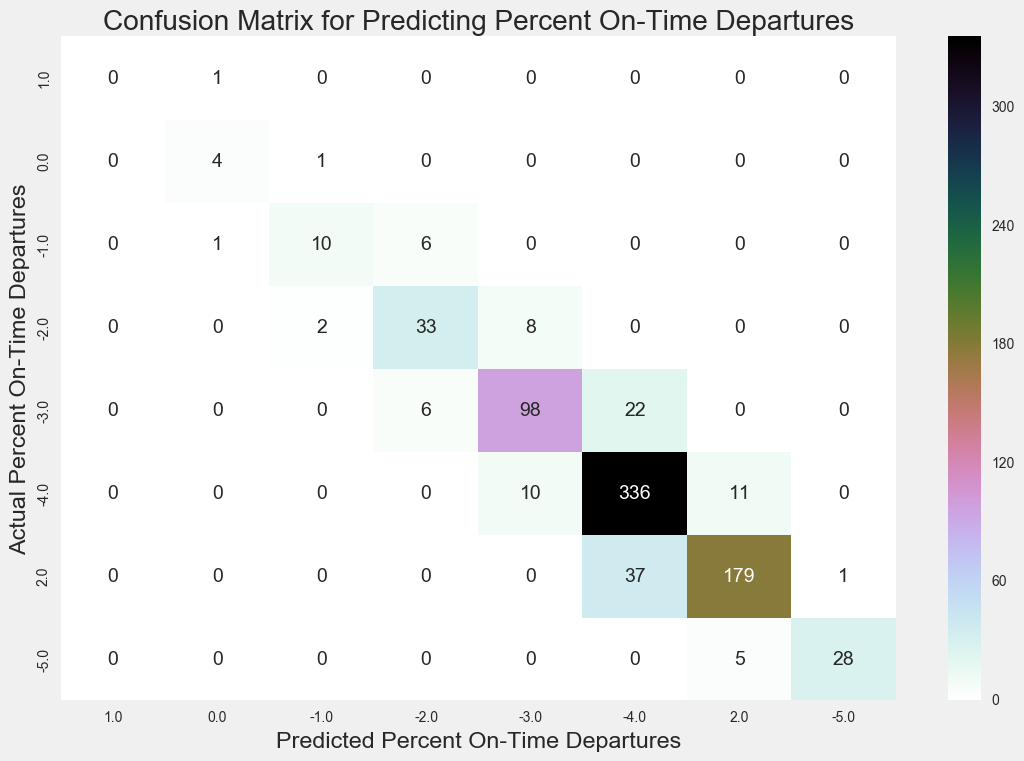

In [22]:
con_matrix = pd.DataFrame(confusion_matrix(engineered_y, knn_predictions), columns = engineered_y.unique(), index = engineered_y.unique())

con_matrix_fig = plt.figure(figsize=(12,8))
sns.heatmap(con_matrix, annot = True, fmt = 'd', cmap = 'cubehelix_r')
plt.title("Confusion Matrix for Predicting Percent On-Time Departures")
plt.xlabel("Predicted Percent On-Time Departures")
plt.ylabel("Actual Percent On-Time Departures")
plt.show()

# Report

The FAA provided three datasets for analysis:

* The `operations` dataset provides information related to arrivals, departures, and delays collected between 2004 and 2014. 
* The `cancellations` dataset lists information related to cancellations and diversion collected between 2004 and 2014. 
* The `airports` dataset contains a catalog of 5167 airports in all 50 states and Puerto Rico: 4876 are designated for public use (municipal or state-operated airports), while 288 are under federal supervision. These are mapped below.

In [23]:
print("{} total airports:".format(airports_data["AP Type"].shape[0]))
print(airports_data["AP Type"].value_counts())

5167 total airports:
Public Use                4876
Federalized/Commercial     288
Name: AP Type, dtype: int64


In [24]:
# map_fig

When exploring the data, we can see large variations in airport performance, as measured by on-time arrivals and departures.

In [25]:
# airport_comparison_fig

Between 2004 and 2014, most of the performance metric declined.

In [26]:
# percent_change_figure

In [27]:
# distribution_of_percent_on_time_departures

In [28]:
# percent_on_time_figure

In [29]:
# departures_arrivals_figure

In [30]:
# explained_variance_fig

In [31]:
# LIST OF FIGURES
## map_fig
## airport_comparison_fig
## percent_change_figure
## distribution_of_percent_on_time_departures
## percent_on_time_figure
## departures_arrivals_figure
## explained_variance_fig
# con_matrix_fig